In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.6.0


In [2]:
# Create a list with the filepaths for training and testing
train_dir = Path(r"dataset\train")
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [3]:
test_dir = Path(r'dataset\test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [4]:
val_dir = Path(r'dataset\validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [5]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [6]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [7]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['chilli pepper' 'capsicum' 'lettuce' 'bell pepper' 'cauliflower' 'garlic'
 'cucumber' 'banana' 'mango' 'cabbage' 'apple' 'potato' 'pineapple' 'corn'
 'spinach' 'watermelon' 'onion' 'peas' 'kiwi' 'tomato' 'eggplant' 'carrot'
 'turnip' 'sweetpotato' 'soy beans' 'raddish' 'beetroot' 'pomegranate'
 'grapes' 'paprika' 'jalepeno' 'orange' 'ginger' 'pear' 'sweetcorn'
 'lemon']


In [8]:
train_df.head(5)

,Filepath,Label
0,dataset\train\chilli pepper\Image_3.jpg,chilli pepper
1,dataset\train\capsicum\Image_48.jpg,capsicum
2,dataset\train\lettuce\Image_77.jpg,lettuce
3,dataset\train\bell pepper\Image_82.jpg,bell pepper
4,dataset\train\cauliflower\Image_98.jpg,cauliflower


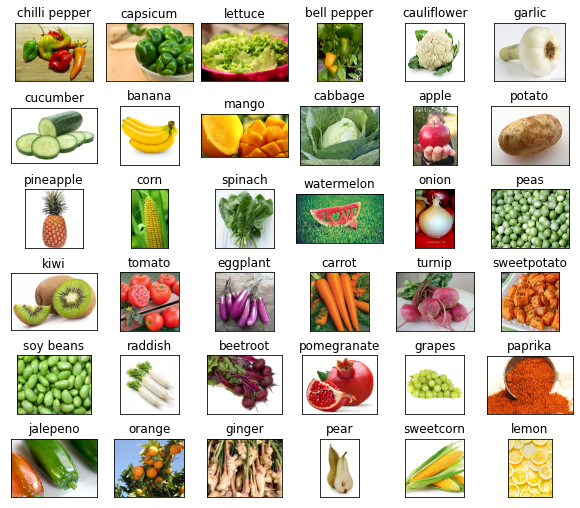

In [9]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2855 validated image filenames belonging to 36 classes.


In [12]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [13]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [14]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [15]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
90/90 [==============================] - 262s 3s/step - loss: 1.7778 - accuracy: 0.5454 - val_loss: 0.4660 - val_accuracy: 0.8588
Epoch 2/5
90/90 [==============================] - 253s 3s/step - loss: 0.5670 - accuracy: 0.8186 - val_loss: 0.2823 - val_accuracy: 0.9206
Epoch 3/5
90/90 [==============================] - 263s 3s/step - loss: 0.3374 - accuracy: 0.8879 - val_loss: 0.2474 - val_accuracy: 0.9176
Epoch 4/5
90/90 [==============================] - 252s 3s/step - loss: 0.2179 - accuracy: 0.9313 - val_loss: 0.2129 - val_accuracy: 0.9559
Epoch 5/5
90/90 [==============================] - 330s 4s/step - loss: 0.1549 - accuracy: 0.9492 - val_loss: 0.1925 - val_accuracy: 0.9529


In [16]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

['ginger',
 'lettuce',
 'sweetcorn',
 'apple',
 'cabbage',
 'potato',
 'lettuce',
 'eggplant',
 'peas',
 'jalepeno',
 'beetroot',
 'peas',
 'eggplant',
 'pear',
 'turnip',
 'soy beans',
 'capsicum',
 'pomegranate',
 'kiwi',
 'sweetpotato',
 'mango',
 'garlic',
 'eggplant',
 'pomegranate',
 'lettuce',
 'sweetcorn',
 'mango',
 'apple',
 'carrot',
 'paprika',
 'beetroot',
 'beetroot',
 'sweetcorn',
 'kiwi',
 'sweetpotato',
 'cabbage',
 'grapes',
 'cucumber',
 'turnip',
 'eggplant',
 'beetroot',
 'peas',
 'garlic',
 'lemon',
 'carrot',
 'spinach',
 'garlic',
 'apple',
 'sweetpotato',
 'beetroot',
 'chilli pepper',
 'banana',
 'eggplant',
 'jalepeno',
 'banana',
 'sweetcorn',
 'orange',
 'chilli pepper',
 'pineapple',
 'ginger',
 'mango',
 'peas',
 'cucumber',
 'pineapple',
 'capsicum',
 'carrot',
 'watermelon',
 'pomegranate',
 'kiwi',
 'lemon',
 'ginger',
 'turnip',
 'banana',
 'spinach',
 'cauliflower',
 'watermelon',
 'pineapple',
 'grapes',
 'raddish',
 'sweetcorn',
 'spinach',
 'pear'

In [17]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [20]:
img = output(r'dataset\test\cabbage\Image_1.jpg')
img

'cabbage'

In [21]:
model.save('FV.h5')

C:\Users\dell\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
